# Experimenting with cloud cover

The basic NetCDF colocation files produced at NASA.GSFC Code 613 are

|    File Name                   | Satellite       |
|--------------------------------|-----------------|
| giant_C6_10km_Aqua_20151005.nc | Aqua            |
| giant_C6_10km_Terra_20150921.nc | Terra          |

These co-locations are based on +/- 30 minutes with a radius of 25 km around each AERONET station. Additonally the following ancillaty data are provided on the same locations:

|    File Name                   |    Satellite | Contents     |
|--------------------------------|--------------|--------------|
|mod_giant_C6_10km_Terra_20150921_CoxMunkBRF.npz        | Terra | Oceanic Bi-diretional Reflection Function
|mod_giant_C6_10km_Terra_20150921_MCD43C1.npz           | Terra | Land BRDF kernels
|mod_giant_C6_10km_Terra_20150921_MERRA2.npz            | Terra | Land/ocean aerosol speciation from MERRA-2 
|mod_giant_C6_10km_Terra_20150921_MOD43BClimAlbedo.npz  | Terra | Climatological Albedo
|mod_giant_C6_10km_Terra_20150921_NDVI.npz              | Terra | NDVI = Normalized Difference Vegetation Index
|myd_giant_C6_10km_Aqua_20151005_CoxMunkBRF.npz         | Aqua  | Oceanic Bi-diretional Reflection Function
|myd_giant_C6_10km_Aqua_20151005_MCD43C1.npz            | Aqua  | Land BRDF kernels
|myd_giant_C6_10km_Aqua_20151005_MERRA2.npz             | Aqua  | Land/ocean aerosol speciation from MERRA-2
|myd_giant_C6_10km_Aqua_20151005_MOD43BClimAlbedo.npz   | Aqua  | Climatological Albedo
|myd_giant_C6_10km_Aqua_20151005_NDVI.npz               | Aqua  | NDVI = Normalized Difference Vegetation Index


## Reading, trimming and quality-controlling co-location files

The raw co-location file including missing values, data which did not produced reliable physical retrievals. In addition, external ancillary information are needed for defining good ML models for deriving aerosol optical depth from satelite reflectances. The following classes perform all of these tasks (based on domain expertise).


In [1]:
from qc_c6 import QC_OCEAN, QC_LAND, QC_DEEP

aqua  = 'data/giant_C6_10km_Aqua_20151005.nc'
terra = 'data/giant_C6_10km_Terra_20150921.nc'

# Ocean Model: Features
Angles = ['SolarZenith','ScatteringAngle', 'GlintAngle'] # Satellite geometry

Reflectances = [   'mRef470',
                   'mRef550',
                   'mRef660',
                   'mRef870',
                   'mRef1200',
                   'mRef1600',
                   'mRef2100'] # Satellite reflectance
  
Surface = [   'CxAlbedo470',
              'CxAlbedo550',
              'CxAlbedo660',
              'CxAlbedo870',
              'CxAlbedo1200',
              'CxAlbedo1600',
              'CxAlbedo2100' ] # Derived from satellite as well
  
Species = [ 'fdu','fcc','fsu']

Other = [ 'cloud', ]

Features = Angles + Reflectances + Surface + Species + Other


# Ocean Model: Targets (In-situ AERONET Measurements)
Target = ['aTau470','aTau550','aTau660','aTau870']

# Ingest Quality Controled Data
Albedo = ['CxAlbedo'] # surface characteristics
aFilter = Surface     # additional filters based on choice of surface
modo = QC_OCEAN(terra,Albedo=Albedo,verbose=True,aFilter=aFilter,
                cloud_thresh=0.80,
                glint_thresh=40.0,
                outliers=3.)


Outlier removal: -1   sig_d = 0.361900  nGood=42363 
Outlier removal: 0   sig_d = 0.295537  nGood=41278 
Outlier removal: 1   sig_d = 0.274959  nGood=40351 
Outlier removal: 2   sig_d = 0.266224  nGood=39852 


In [2]:
features = modo.toDataFrame(Vars=Features)
features.describe()

,SolarZenith,ScatteringAngle,GlintAngle,mRef470,mRef550,mRef660,mRef870,mRef1200,mRef1600,mRef2100,...,CxAlbedo550,CxAlbedo660,CxAlbedo870,CxAlbedo1200,CxAlbedo1600,CxAlbedo2100,fdu,fcc,fsu,cloud
count,39852.000000,39852.000000,39852.000000,39852.000000,39852.000000,39852.000000,39852.000000,39852.000000,39852.000000,39852.000000,...,3.985200e+04,3.985200e+04,3.985200e+04,3.985200e+04,3.985200e+04,3.985200e+04,39852.000000,39852.000000,39852.000000,39852.000000
mean,0.728992,-0.605486,0.456344,0.148652,0.091478,0.056198,0.028949,0.016439,0.010893,0.007547,...,2.095237e-04,2.074116e-04,2.042562e-04,2.000732e-04,1.928204e-04,1.816013e-04,0.253706,0.200073,0.404352,0.279755
std,0.167209,0.301721,0.242133,0.034386,0.027732,0.022740,0.017958,0.014930,0.012720,0.010241,...,8.516044e-04,8.430070e-04,8.301635e-04,8.131379e-04,7.836195e-04,7.379626e-04,0.209908,0.118880,0.178920,0.245552
min,0.169693,-0.999979,-0.299374,0.087000,0.048000,0.025000,0.009000,0.003000,0.001000,0.001000,...,2.167380e-38,2.145146e-38,2.111940e-38,2.067935e-38,1.991680e-38,1.873838e-38,0.000134,0.006523,0.008762,0.001000
25%,0.614147,-0.869236,0.285688,0.124000,0.072000,0.041000,0.019000,0.009000,0.005000,0.003000,...,9.685454e-15,9.588113e-15,9.442687e-15,9.249738e-15,8.908119e-15,8.380240e-15,0.094747,0.119272,0.273887,0.054000
50%,0.760463,-0.711413,0.532064,0.141000,0.085000,0.050000,0.024000,0.012000,0.007000,0.005000,...,7.874023e-09,7.796133e-09,7.678105e-09,7.518851e-09,7.242843e-09,6.819703e-09,0.187867,0.179151,0.407476,0.208000
75%,0.871300,-0.329361,0.652760,0.166000,0.104000,0.064000,0.033000,0.018000,0.012000,0.008000,...,1.293812e-05,1.280625e-05,1.260803e-05,1.234762e-05,1.191017e-05,1.121758e-05,0.350449,0.252886,0.535475,0.481000
max,0.996737,0.201591,0.765932,0.396000,0.381000,0.404000,0.391000,0.386000,0.355000,0.339000,...,1.655733e-02,1.638842e-02,1.613611e-02,1.580172e-02,1.522215e-02,1.432621e-02,0.972579,0.904949,0.935364,0.799000


In [3]:
target = modo.toDataFrame(Vars=Target)
target.describe()

,aTau470,aTau550,aTau660,aTau870
count,39852.000000,39852.000000,39852.000000,39852.000000
mean,0.200230,0.170303,0.141923,0.110887
std,0.188391,0.169068,0.150931,0.132381
min,0.012000,0.009000,0.006000,-0.009000
25%,0.085000,0.071000,0.058000,0.043000
50%,0.139000,0.116000,0.094000,0.071000
75%,0.250000,0.209000,0.170000,0.127000
max,4.027000,4.038000,4.005000,3.864000


Text(0, 0.5, 'counts')

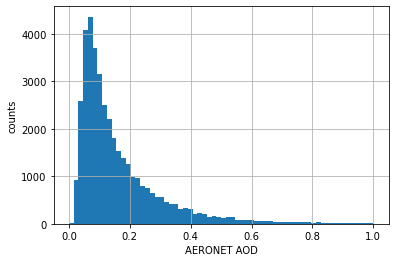

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # for KDE

plt.hist(modo.aTau550,64,range=(0,1))
plt.grid()
plt.xlabel('AERONET AOD')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

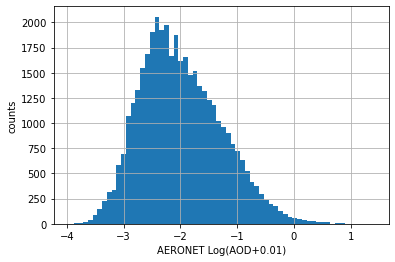

In [8]:


plt.hist(np.log(modo.aTau550+0.01),64)
plt.grid()
plt.xlabel('AERONET Log(AOD+0.01)')
plt.ylabel('counts')


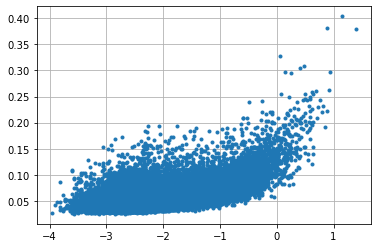

In [17]:
plt.plot(np.log(modo.aTau550+0.01),modo.mRef660,'.')
plt.grid()

## Task 1

 1. Consider the *Ocean* case above to start
 1. Train a simple MLP model using the *Features* and *Target* above
 2. Repeat omiting the *Surface* from the *Features*
 2. Train an Evidential Deep Regression model
 
### Remarks

 1. AOD is a very skewed variable. Consider Log(AOD+*eps*) where *eps* is a small number; typically 0.01
 2. Consider coming up with an objective way of determining *eps*. For example, minimizing the KL divergence of the transformed variable and the corresponding normal distribution.
 